In [1]:
from pathlib import Path

thispath = Path('__file__').resolve()
base_path = thispath.parent.parent
import sys; sys.path.insert(0, str(base_path))
from dataset.copd_dataset import DirLabCOPD
from utils import metrics

In [2]:
NORMALIZATION_CFG = {
    'norm_type': 'min-max',
    'mask': None,
    'max_val': 255,
    'window': [-1024, 600],
    'dtype': 'uint8',
}

data = DirLabCOPD(
    cases=['all'],
    partitions=['train'],
    return_lm_mask=True,
    normalization_cfg=NORMALIZATION_CFG
)

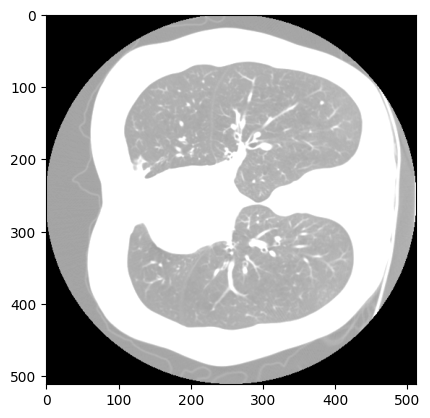

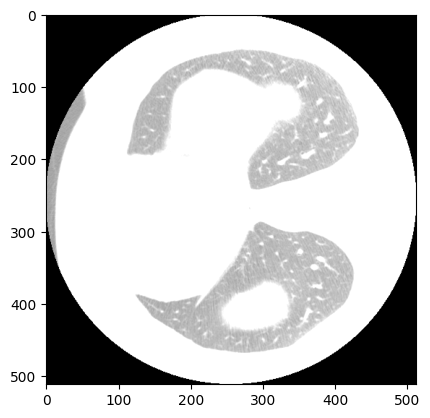

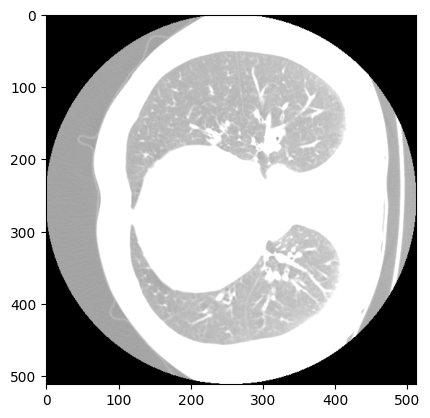

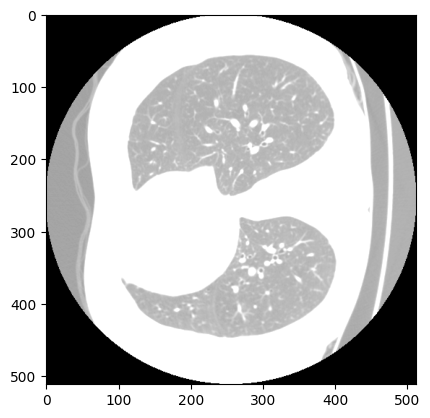

In [3]:
import matplotlib.pyplot as plt

for i in range(len(data)):
    sample = data[i]
    plt.figure()
    plt.imshow(sample['i_img'][:,:,75], cmap='gray')
    plt.show()
    # break

In [4]:
import SimpleITK as sitk


In [ ]:
import elastix.elastix_utils as e_utils

# Define parameter maps to use
param_maps_to_use = ['Par0003.affine.txt']
output_path = Path('/home/jseia/Desktop/MAIA/classes/spain/mira/final_project/mira_final_project/experiments/elastix')
params_path = Path('/home/jseia/Desktop/MAIA/classes/spain/mira/final_project/mira_final_project/elastix/parameter_maps')
# Define fixed imgage to use
for i in range(len(data)):
    sample = data[i]
    for pm in param_maps_to_use:
        # Define output paths
        output_pm_path = output_path / pm.rstrip('.txt')
        output_pm_path.mkdir(exist_ok=True, parents=True)

        # Read and modify parameters file
        parameters_filename = params_path / pm
        result_path = output_pm_path / sample['case']
        result_path.mkdir(exist_ok=True, parents=True)
        
        field_value_pairs = [('ResultImageFormat', 'nii.gz')]
        e_utils.modify_field_parameter_map(field_value_pairs, parameters_filename)

        # Register
        transform_map_path = e_utils.elastix_wrapper(sample['e_img_path'], sample['i_img_path'], result_path, parameters_filename)
    break
        # Correct transformation parameters file
        # field_value_pairs = [
        #     ('ResultImageFormat', 'nii.gz'),
        #     ('ResultImagePixelType', "float"),
        #     ('FinalBSplineInterpolationOrder', '2.0')
        # ]
        # e_utils.modify_field_parameter_map(field_value_pairs, transform_map_path)

        # Transform labels
        # e_utils.transformix_wrapper(mov_lab_path, res_lab_path, transform_map_path)

        # Transform brain_mask
        # utils.transformix_wrapper(mov_mask_path, res_mask_path, transform_map_path)


AttributeError: module 'SimpleITK' has no attribute 'ReadParameterFile'